### Ejemplo sobre imbalanced data

En este ejemplo se pretende mostrar una manera muy interesante de generar datos sintéticos cuando el dataset está desbalanceado. En concreto, estaríamos hablando de redes GAN, o redes generativas antagónicas, y adversarial learning.

La idea consiste en utilizar 2 tipos de redes: una generativa y otra discriminadora. La discriminadora ayuda a la generadora a ofrecer resultados más certeros y tan similares a los datos reales que, cuando convergen, no se pueden llegar a diferenciar.

Referencia: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

### Señales unidimensionales

Normalmente se utilizan para la generación de imágenes sintéticas, pero en este caso nos vamos a centrar en señales unidimensionales, "fácilmente" extrapolables a señales y patrones temporales. Vamos a verlo...

En primera instancia, necesitamos importar funcionalidad del paquete 'keras', ya que las GAN se basan en redes deep.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import numpy as np
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from random import seed
seed(42)

Using TensorFlow backend.


Definimos la red discriminadora

In [2]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Definimos la red generadora

In [3]:
def define_generator(latent_dim, 
                     n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

Ahora definimos el modelo que combina la red generadora y discriminadora, para ir actualizando la primera de las dos

In [4]:
def define_gan(generator, 
               discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

Generamos 'n' datos reales con sus correspondientes etiquetas

In [5]:
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

Generamos una serie de puntos en el espacio "latente" o implícito, no directamente observable, como entrada del modelo generativo. Típicamente se trata de una hiperesfera con cada variable proyectada desde una distribución Gausiana con media 0 y desviación 1. A través del entrenamiento el modelo generador aprende a mapear los puntos en este espacio "latente" con señales unidimensionales específicas de manera incremental

In [6]:
def generate_latent_points(latent_dim, 
                           n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

Utilizar la red generativa para generar 'n' señales sintéticas, con las correspondientes etiquetas

In [7]:
def generate_fake_samples(generator, 
                          latent_dim, 
                          n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

Pasarle los datos generados a la red discriminadora y plotear los puntos reales y los sintéticos

In [8]:
def summarize_performance(epoch, 
                          generator, 
                          discriminator, 
                          latent_dim, 
                          n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    plt.figure()
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.show()
    return x_real, y_real, x_fake, y_fake

Entrenar los modelos generador y discriminador

In [9]:
def train(g_model, 
          d_model, 
          gan_model, 
          latent_dim, 
          n_epochs=10000, 
          n_batch=128, 
          n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            x_real, y_real, x_fake, y_fake = summarize_performance(i, g_model, d_model, latent_dim)
    return x_real, y_real, x_fake, y_fake

Ejecutamos y vemos resultados

1999 0.5099999904632568 1.0


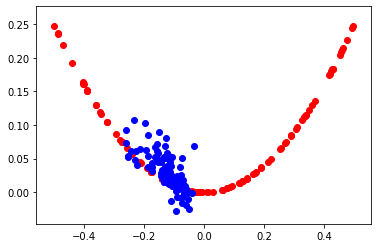

3999 0.5 0.6899999976158142


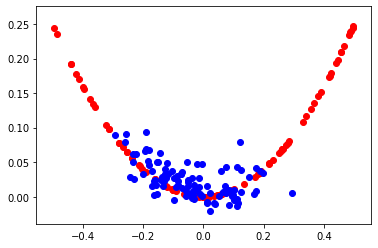

5999 0.07000000029802322 0.9800000190734863


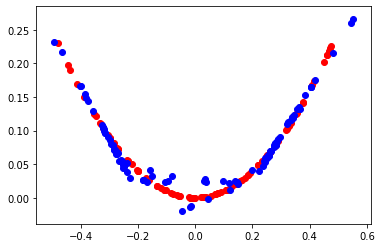

7999 0.5099999904632568 0.6000000238418579


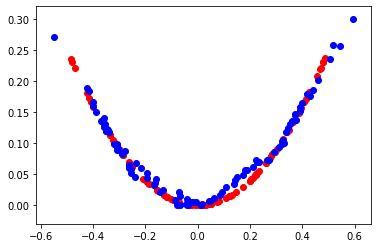

9999 0.6100000143051147 0.5099999904632568


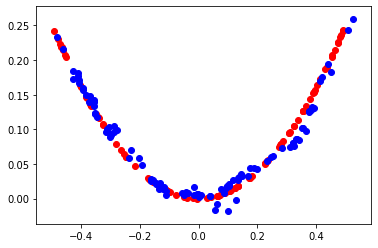

In [10]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
x_real, y_real, x_fake, y_fake = train(generator, discriminator, gan_model, latent_dim)

In [11]:
print('Real: ' + str(np.unique(np.round(discriminator.predict(x_real)).reshape(1,-1)[0], return_counts=True)))
print('Sintético: ' + str(np.unique(np.round(discriminator.predict(x_fake)).reshape(1,-1)[0], return_counts=True)))

Real: (array([0., 1.], dtype=float32), array([39, 61], dtype=int64))
Sintético: (array([0., 1.], dtype=float32), array([51, 49], dtype=int64))


Se puede apreciar que el proceso de entrenamiento es relativamente inestable. Primero se muestra la iteración (epochs), en segunda instancia la precisión del modelo discriminador al clasificar casos reales y, finalmente, la precisión conseguida al utilizar señales sintéticas.

La red discriminadora se mantienen confusa con los casos reales y con los datos sintéticos. Queda trabajo por hacer en esta línea...